First the libraries and packages needed will be imported, also the file and information about the dataset will be looked at to see if first of all there are missing values.

In [1]:
########################################
# Importing packages.
########################################
import matplotlib.pyplot as plt                      # Data visualization.
import seaborn as sns                                # Data visualization.
import pandas as pd                                  # Data science essentials.
from sklearn.model_selection import train_test_split # Train-test split.
from sklearn.linear_model import LogisticRegression  # Logistic regressio.
import statsmodels.formula.api as smf                # Logistic regression.
from sklearn.metrics import roc_auc_score            # Auc score.
from sklearn.metrics import confusion_matrix         # Confusion matrix.
from scipy.stats import pearsonr                     # Correlation.
from sklearn.ensemble import RandomForestClassifier  # Random Forest.
from sklearn.datasets import make_classification     # Random Forest.

# CART model packages.
from sklearn.tree import DecisionTreeClassifier      # Classification trees.
from sklearn.tree import plot_tree                   # Tree plots.


# Importing for hyperparamter tuning.
from sklearn.model_selection import RandomizedSearchCV     # Hyperparameter tuning.
from sklearn.metrics import make_scorer              # Customizable scorer.


########################################
# Loading data and setting display options.
########################################
# Loading data.
file = './__dataset/GOT_character_predictions.xlsx'
got = pd.read_excel(io = file)
# Setting display options.
pd.set_option('display.max_rows', got.shape[0]+1, "display.max_columns", 
              got.shape[0]+1)
# Getting data info.
got.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   int64  
 1   name                        1946 non-null   object 
 2   title                       938 non-null    object 
 3   culture                     677 non-null    object 
 4   dateOfBirth                 433 non-null    float64
 5   mother                      21 non-null     object 
 6   father                      26 non-null     object 
 7   heir                        23 non-null     object 
 8   house                       1519 non-null   object 
 9   spouse                      276 non-null    object 
 10  book1_A_Game_Of_Thrones     1946 non-null   int64  
 11  book2_A_Clash_Of_Kings      1946 non-null   int64  
 12  book3_A_Storm_Of_Swords     1946 non-null   int64  
 13  book4_A_Feast_For_Crows     1946 

Now I will use the professors function to flag missing values and create new columns.

In [2]:
# user-defined functions

#########################
# mv_flagger
#########################
def mv_flagger(df):
    """
Flags all columns that have missing values with 'm-COLUMN_NAME'.

PARAMETERS
----------
df : DataFrame to flag missing values


RETURNS
-------
DataFrame with missing value flags."""


    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df



#########################
# text_split_feature
#########################
def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))

In [3]:
# running the mv_flagger function
got = mv_flagger(df = got)


# checking results
got.columns


#checking for missing values
got.isnull().any()

S.No                          False
name                          False
title                          True
culture                        True
dateOfBirth                    True
mother                         True
father                         True
heir                           True
house                          True
spouse                         True
book1_A_Game_Of_Thrones       False
book2_A_Clash_Of_Kings        False
book3_A_Storm_Of_Swords       False
book4_A_Feast_For_Crows       False
book5_A_Dance_with_Dragons    False
isAliveMother                  True
isAliveFather                  True
isAliveHeir                    True
isAliveSpouse                  True
isMarried                     False
isNoble                       False
age                            True
numDeadRelations              False
popularity                    False
isAlive                       False
m_title                       False
m_culture                     False
m_dateOfBirth               

Now the objective will be to engineer the sex of the observations, for this, using the titanic idea, a loop will be created to find 'male' roles in the titles and assign values to them. The logic behind this will be that since there are more male titles, and more specific ones, the males will take a 1 and the females or the unknown a 0. This way we will know at least who is male guaranteed and the error will lie in the female side.

In [4]:
 # Making sure that it is all string.
got['title'] = got['title'].astype(str)
# Finding titles if male or female and assigning them to new feature.
got['male'] = 0
# Creating loop to run through the dataframe.
for index, val in got.iterrows():
     # Checking for male titles.
    if ('lord' in got.loc[ index , 'title'].lower() 
        or 'ser'in got.loc[ index , 'title'].lower() 
        or 'hand'in got.loc[ index , 'title'].lower() 
        or 'archmaester' in got.loc[ index , 'title'].lower()
        or 'maester' in got.loc[ index , 'title'].lower()
        or 'khal' in got.loc[ index , 'title'].lower()
        or'brother' in got.loc[ index , 'title'].lower()
        or 'prince' in got.loc[ index , 'title'].lower()
        or 'septon' in got.loc[ index , 'title'].lower()
        or 'king' in got.loc[ index , 'title'].lower()
        or 'senschal' in got.loc[ index , 'title'].lower()
        or 'bloodrider'in got.loc[ index , 'title'].lower()
        or 'steward' in got.loc[ index , 'title'].lower()
        or 'cupbearer'in got.loc[ index , 'title'].lower()
        or 'master' in got.loc[ index , 'title'].lower()
        or 'captain' in got.loc[ index , 'title'].lower()
        or'general'in got.loc[ index , 'title'].lower()
        or 'commander'in got.loc[ index , 'title'].lower()
        or 'sword'in got.loc[ index , 'title'].lower()
        or 'ranger'in got.loc[ index , 'title'].lower()
        or 'knight'in got.loc[ index , 'title'].lower()
        or 'sealord' in got.loc[ index , 'title'].lower()):
         got.loc[index, 'male'] = 1

        # Checking for female titles. 
    elif ('queen' in got.loc[ index , 'title'].lower()
        or 'red'in got.loc[ index , 'title'].lower()
        or 'princess'in got.loc[ index , 'title'].lower() 
        or 'lady'in got.loc[ index , 'title'].lower()
        or 'septa' in got.loc[ index , 'title'].lower()
        or 'bride' in got.loc[ index , 'title'].lower()
        or'goodwife'in got.loc[ index , 'title'].lower() 
        or 'witch' in got.loc[ index , 'title'].lower()
        or 'pinkmaiden'in got.loc[ index , 'title'].lower() 
        or 'widow' in got.loc[ index , 'title'].lower()):
        got.loc[index, 'male'] = 0
    else:
        got.loc[index, 'male'] = 0


Now the idea is to analyze the data. Just looking at the variables there were two that directly pointed out that they were related, dateOfBirth and age should be completely correlated but in a negative way. 

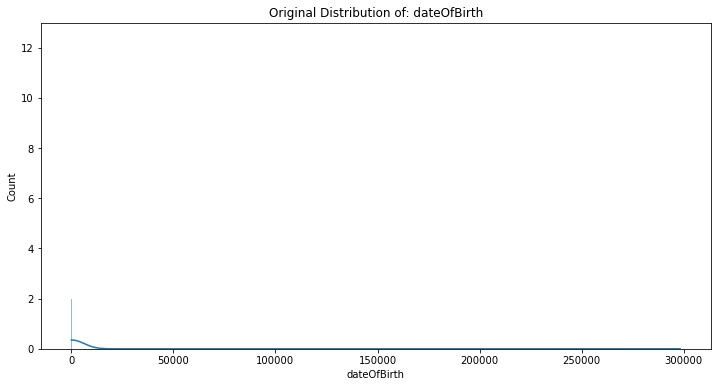

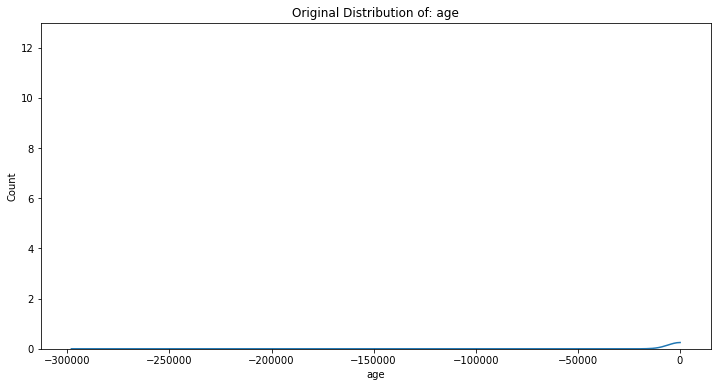

In [5]:
# Creating a list of the features.
got_list_1 = ['dateOfBirth','age']
# Creating a loop to print a histogram for every variable.
for j in got_list_1:
    fig, ax = plt.subplots(figsize=(12, 6))
# Using seaborn to create the plots. 
    sns.histplot(data = got,
          x      = j,
          kde    = True)

# Title and axis labels.
    plt.title(label   = (f"""Original Distribution of: {j}"""))
    plt.xlabel(xlabel = j) # avoiding using dataset labels
    plt.ylabel(ylabel = "Count")
    plt.ylim([0, 13])

# Displaying the histograms.
    plt.show()

Now we can also observe something, most of the data is between a 'standard range', but there are some weird very big outliers. Nevertheless, they might be legit data, so to not get distorted by those extreme values, I will fill in the empty values with the median.

In [6]:
# Finding the median.
birth_date_median = got['dateOfBirth'].median()
# Substituting the median.
got['dateOfBirth'] = got['dateOfBirth'].fillna(birth_date_median).round(4)
# Finding the median.
age_median = got['age'].median()
# Substituting the median.
got['age'] = got['age'].fillna(age_median).round(4)

Now I am filling in the empty values of the isAlive... If they are missing values, I will substitute with a 0 assuming they are dead.

In [7]:
# Filling out empty values with 0.
got['isAliveMother'] = got['isAliveMother'].fillna(0)
got['isAliveFather'] = got['isAliveFather'].fillna(0)
got['isAliveSpouse'] = got['isAliveSpouse'].fillna(0)
got['isAliveHeir'] = got['isAliveHeir'].fillna(0)

Now I will engineer new features to try to improve the model, first will be if they noble and popular at the same time. This is because I did some research and it pointed out the following:
- Noble is more likely to be alive
- Popular is more likely to be alive
- If they are in book one most likely dead
- If they are married and noble most likely alive 

In [8]:
# Createing new feature.
got['n_pop'] =0
# Creating loop to run through the dataframe.
for index, val in got.iterrows():
    # Checking for popular.
    if got.loc[ index , 'popularity'] >= 0.5:
        got.loc[index, 'n_pop'] = 1
    else:
        got.loc[index, 'n_pop'] = 0
        
# Createing new feature.        
got['n_pop_nob'] =0
# Creating loop to run through the dataframe.
for index, val in got.iterrows():
    # Setting up condition.
    if got.loc[ index , 'n_pop'] == got.loc[ index , 'isNoble']:
        got.loc[index, 'n_pop_nob'] = 1
    else:
        got.loc[index, 'n_pop_nob'] = 0
        
# Createing new feature.
got['n_b1_pop'] =0
# Creating loop to run through the dataframe.
for index, val in got.iterrows():
    # Setting up condition.
    if got.loc[ index , 'n_pop'] == got.loc[ index , 'book1_A_Game_Of_Thrones']:
        got.loc[index, 'n_b1_pop'] = 0
    else:
        got.loc[index, 'n_b1_pop'] = 1

# Createing new feature.
got['n_married_popular'] =0
# Creating loop to run through the dataframe.
for index, val in got.iterrows():
    # Setting up condition.
    if got.loc[ index , 'n_pop'] == got.loc[ index , 'isMarried']:
        got.loc[index, 'n_married_popular'] = 1
    else:
        got.loc[index, 'n_married_popular'] = 0

Dropping categorical variables

In [9]:
# Dropping categorical features and S.No.
got = got.drop(['S.No'],axis=1)
got = got.drop(['name'],axis=1)
got = got.drop(['house'],axis=1)
got = got.drop(['title'],axis=1)
got = got.drop(['culture'],axis=1)
got = got.drop(['mother'],axis=1)
got = got.drop(['father'],axis=1)
got = got.drop(['heir'],axis=1)
got = got.drop(['spouse'],axis=1)

In [10]:
# Checking for correlation.
got_corr = got.corr(method = 'pearson').round(decimals = 2)
got_corr['isAlive'].sort_values(ascending = False)

isAlive                       1.00
book4_A_Feast_For_Crows       0.27
m_dateOfBirth                 0.15
m_age                         0.15
m_isAliveFather               0.14
m_isAliveMother               0.14
m_father                      0.14
m_mother                      0.14
m_isAliveHeir                 0.13
m_heir                        0.13
n_married_popular             0.09
n_pop_nob                     0.06
m_isAliveSpouse               0.05
m_spouse                      0.05
age                           0.05
m_house                       0.04
m_culture                     0.04
m_title                       0.04
book5_A_Dance_with_Dragons    0.03
book3_A_Storm_Of_Swords       0.01
isAliveSpouse                -0.01
male                         -0.03
isAliveFather                -0.04
isNoble                      -0.04
dateOfBirth                  -0.05
isMarried                    -0.05
book2_A_Clash_Of_Kings       -0.07
isAliveHeir                  -0.08
isAliveMother       

Now that the data has been cleaned, model building.

In [11]:
# Declaring explanatory variables.
got_data = got.drop('isAlive',axis = 1)
# Declaring response variable.
got_target = got.loc[ : ,'isAlive']

Now the split will be made with the assignments criteria.

In [12]:
# Train-test split with stratification.
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = got_target) # preserving balance


# Merging training data for statsmodels.
got_train = pd.concat([x_train, y_train], axis = 1)
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")



Response Variable Proportions (Training Set)
--------------------------------------------
1    0.75
0    0.25
Name: isAlive, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.74
0    0.26
Name: isAlive, dtype: float64



Running logistic regressions.

In [13]:
# Instantiating a logistic regression model object.
logistic_small = smf.logit(formula = """isAlive ~  dateOfBirth +
                                                    book1_A_Game_Of_Thrones +
                                                    book2_A_Clash_Of_Kings +
                                                    book3_A_Storm_Of_Swords +
                                                    book4_A_Feast_For_Crows +
                                                    age +
                                                    popularity""",
                           data    = got_train)


# Fitting the model object.
results_logistic = logistic_small.fit()


# Checking the results summary.
results_logistic.summary2() # Summary2() has AIC and BIC.


Optimization terminated successfully.
         Current function value: 0.435888
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.231     
Dependent Variable:    isAlive             AIC:                 1542.4811 
Date:                  2021-12-05 21:35    BIC:                 1586.2247 
No. Observations:      1751                Log-Likelihood:      -763.24   
Df Model:              7                   LL-Null:             -992.53   
Df Residuals:          1743                LLR p-value:         6.3572e-95
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        10.0000                                            
--------------------------------------------------------------------------
                         Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------------
Intercept               -62.7595   8.1140 -7.7347 0.0000 -78.6627 -46.8563
dateOfBirth               0.2168   0.0276  7.8705 0.0000   0.1628   0.2708
book1_A_Game_Of_Thrones  -0.6013   0.1608 -3.7402 0.0002  -0.9164  -0.2862
book2_A_Clash_Of_Kings   -0.6211   0.1451 -4.2815 0.0000  -0.9054  -0.3368
book3_A_Storm_Of_Swords  -0.4926   0.1509 -3.2644 0.0011  -0.7884  -0.1969
book4_A_Feast_For_Crows   1.3876   0.1497  9.2699 0.0000   1.0942   1.6809
age                       0.2169   0.0276  7.8714 0.0000   0.1629   0.2709
popularity               -2.7485   0.3964 -6.9329 0.0000  -3.5255  -1.9715
==========================================================================

"""

In [14]:
# Instantiating a logistic regression model object.
logistic_full = smf.logit(formula = """  isAlive ~  dateOfBirth +
                                                    book1_A_Game_Of_Thrones +
                                                    book2_A_Clash_Of_Kings +
                                                    book3_A_Storm_Of_Swords +
                                                    book4_A_Feast_For_Crows +
                                                    book5_A_Dance_with_Dragons +
                                                    isMarried +
                                                    isNoble +
                                                    age +
                                                    numDeadRelations +
                                                    popularity +
                                                    m_house+
                                                    m_culture """,
                                         data    = got_train)


# Fitting the model object.
results_full = logistic_full.fit()


# Checking the results summary.
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.433400
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Logit
=============================================================================
Model:                  Logit                Pseudo R-squared:     0.235     
Dependent Variable:     isAlive              AIC:                  1545.7658 
Date:                   2021-12-05 21:35     BIC:                  1622.3170 
No. Observations:       1751                 Log-Likelihood:       -758.88   
Df Model:               13                   LL-Null:              -992.53   
Df Residuals:           1737                 LLR p-value:          1.2730e-91
Converged:              1.0000               Scale:                1.0000    
No. Iterations:         10.0000                                              
-----------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
-----------------------------------------------------------------------------
Intercept                  -64.1092   8.2581 -7.7632 0.0000 -80.2948 -47.9237
dateOfBirth                  0.2209   0.0280  7.8853 0.0000   0.1660   0.2757
book1_A_Game_Of_Thrones     -0.5520   0.1652 -3.3406 0.0008  -0.8758  -0.2281
book2_A_Clash_Of_Kings      -0.6228   0.1471 -4.2338 0.0000  -0.9111  -0.3345
book3_A_Storm_Of_Swords     -0.4899   0.1536 -3.1887 0.0014  -0.7910  -0.1888
book4_A_Feast_For_Crows      1.4070   0.1616  8.7087 0.0000   1.0903   1.7236
book5_A_Dance_with_Dragons  -0.0947   0.1554 -0.6093 0.5424  -0.3993   0.2099
isMarried                    0.3102   0.2203  1.4082 0.1591  -0.1215   0.7420
isNoble                      0.1355   0.1347  1.0060 0.3144  -0.1285   0.3994
age                          0.2209   0.0280  7.8861 0.0000   0.1660   0.2758
numDeadRelations            -0.0875   0.0616 -1.4205 0.1555  -0.2083   0.0332
popularity                  -2.4801   0.5368 -4.6205 0.0000  -3.5321  -1.4281
m_house                      0.3369   0.1654  2.0371 0.0416   0.0128   0.6611
m_culture                    0.0100   0.1407  0.0711 0.9434  -0.2658   0.2858
=============================================================================

"""

In [15]:
# Instantiating a logistic regression model object.
logistic_full = smf.logit(formula = """  isAlive ~  dateOfBirth +
                                                    book1_A_Game_Of_Thrones +
                                                    book2_A_Clash_Of_Kings +
                                                    book3_A_Storm_Of_Swords +
                                                    book4_A_Feast_For_Crows +
                                                    book5_A_Dance_with_Dragons +
                                                    isMarried +
                                                    isNoble +
                                                    age +
                                                    numDeadRelations +
                                                    popularity +
                                                    male +
                                                    m_title +
                                                    m_culture +
                                                    m_mother+
                                                    m_father+
                                                    m_heir+
                                                    m_house+
                                                    m_spouse""",
                                         data    = got_train)


# fitting the model object.
results_full = logistic_full.fit()
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.432162
         Iterations 11


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: Logit
============================================================================================
Model:                       Logit                     Pseudo R-squared:          0.238     
Dependent Variable:          isAlive                   AIC:                       1551.4303 
Date:                        2021-12-05 21:35          BIC:                       1655.3212 
No. Observations:            1751                      Log-Likelihood:            -756.72   
Df Model:                    18                        LL-Null:                   -992.53   
Df Residuals:                1732                      LLR p-value:               9.4448e-89
Converged:                   1.0000                    Scale:                     1.0000    
No. Iterations:              11.0000                                                        
--------------------------------------------------------------------------------------------
                            Coef.     Std.Err.      z    P>|z|      [0.025         0.975]   
--------------------------------------------------------------------------------------------
Intercept                  -41.4174 9267076.5572 -0.0000 1.0000 -18163177.7114 18163094.8766
dateOfBirth                  0.2093       0.0273  7.6802 0.0000         0.1559        0.2628
book1_A_Game_Of_Thrones     -0.5959       0.1665 -3.5781 0.0003        -0.9223       -0.2695
book2_A_Clash_Of_Kings      -0.6393       0.1476 -4.3318 0.0000        -0.9285       -0.3500
book3_A_Storm_Of_Swords     -0.5202       0.1551 -3.3538 0.0008        -0.8242       -0.2162
book4_A_Feast_For_Crows      1.3997       0.1623  8.6240 0.0000         1.0816        1.7178
book5_A_Dance_with_Dragons  -0.1186       0.1560 -0.7603 0.4471        -0.4244        0.1872
isMarried                  -20.5890 9267076.5572 -0.0000 1.0000 -18163156.8831 18163115.7050
isNoble                      0.1114       0.4593  0.2426 0.8083        -0.7888        1.0116
age                          0.2094       0.0273  7.6811 0.0000         0.1559        0.2628
numDeadRelations            -0.0630       0.0635 -0.9910 0.3217        -0.1875        0.0616
popularity                  -2.0124       0.5901 -3.4101 0.0006        -3.1690       -0.8558
male                        -0.0427       0.2221 -0.1924 0.8474        -0.4781        0.3926
m_title                     -0.0127       0.4929 -0.0257 0.9795        -0.9788        0.9535
m_culture                    0.0533       0.1428  0.3736 0.7087        -0.2265        0.3332
m_mother                     1.0826       1.2273  0.8821 0.3777        -1.3228        3.4880
m_father                     0.1893       1.0492  0.1805 0.8568        -1.8670        2.2456
m_heir                       0.2816       0.9251  0.3044 0.7608        -1.5316        2.0948
m_house                      0.3974       0.1707  2.3279 0.0199         0.0628        0.7321
m_spouse                   -20.8282 9267076.5572 -0.0000 1.0000 -18163157.1223 18163115.4658
============================================================================================

"""

In [16]:
# Instantiating a logistic regression model object.
logistic_full = smf.logit(formula = """  isAlive ~  dateOfBirth +
                                                    book1_A_Game_Of_Thrones +
                                                    book2_A_Clash_Of_Kings +
                                                    book3_A_Storm_Of_Swords +
                                                    book4_A_Feast_For_Crows +
                                                    book5_A_Dance_with_Dragons +
                                                    isMarried +
                                                    isNoble +
                                                    age +
                                                    numDeadRelations +
                                                    popularity +
                                                    male +
                                                    m_title +
                                                    m_culture +
                                                    m_house +
                                                    m_spouse +
                                                    m_mother +
                                                    m_father +
                                                    m_heir +
                                                    n_pop +
                                                    n_pop_nob +
                                                    n_b1_pop 
                                    
                                                    """,
                                         data    = got_train)


# Fitting the model object.
results_full = logistic_full.fit()


# checking the results summary.
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.429348
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                  Logit               Pseudo R-squared:    0.243     
Dependent Variable:     isAlive             AIC:                 1547.5763 
Date:                   2021-12-05 21:35    BIC:                 1667.8711 
No. Observations:       1751                Log-Likelihood:      -751.79   
Df Model:               21                  LL-Null:             -992.53   
Df Residuals:           1729                LLR p-value:         1.0797e-88
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         10.0000                                            
---------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                  -42.5737      nan     nan    nan     nan     nan
dateOfBirth                  0.2105   0.0277  7.5974 0.0000  0.1562  0.2648
book1_A_Game_Of_Thrones     -1.6094   0.8009 -2.0096 0.0445 -3.1791 -0.0397
book2_A_Clash_Of_Kings      -0.6239   0.1483 -4.2079 0.0000 -0.9144 -0.3333
book3_A_Storm_Of_Swords     -0.4865   0.1564 -3.1112 0.0019 -0.7931 -0.1800
book4_A_Feast_For_Crows      1.4189   0.1634  8.6848 0.0000  1.0987  1.7392
book5_A_Dance_with_Dragons  -0.0994   0.1565 -0.6350 0.5255 -0.4061  0.2074
isMarried                  -21.1067      nan     nan    nan     nan     nan
isNoble                      0.8333   0.7614  1.0943 0.2738 -0.6591  2.3257
age                          0.2105   0.0277  7.5982 0.0000  0.1562  0.2648
numDeadRelations            -0.1135   0.0681 -1.6660 0.0957 -0.2470  0.0200
popularity                  -3.8217   0.9039 -4.2280 0.0000 -5.5933 -2.0501
male                        -0.0436   0.2244 -0.1942 0.8461 -0.4833  0.3962
m_title                     -0.0865   0.5023 -0.1722 0.8633 -1.0710  0.8980
m_culture                    0.0444   0.1433  0.3098 0.7567 -0.2365  0.3253
m_house                      0.3753   0.1712  2.1923 0.0284  0.0398  0.7107
m_spouse                   -21.4687      nan     nan    nan     nan     nan
m_mother                     1.6063   1.3268  1.2106 0.2260 -0.9943  4.2069
m_father                     0.1753   1.0187  0.1720 0.8634 -1.8214  2.1719
m_heir                       0.5648   0.9470  0.5963 0.5509 -1.2914  2.4209
n_pop                        2.2235   0.8318  2.6730 0.0075  0.5931  3.8539
n_pop_nob                    0.7764   0.6462  1.2015 0.2296 -0.4901  2.0429
n_b1_pop                     1.0769   0.7945  1.3554 0.1753 -0.4803  2.6341
===========================================================================

"""

In [17]:
# Creating a list with all the variables I will use in the models.
candidate_dict = {

 # Model.
 'logit_full'   : ['dateOfBirth','book1_A_Game_Of_Thrones',
                   'book2_A_Clash_Of_Kings','book3_A_Storm_Of_Swords',
                   'book4_A_Feast_For_Crows','book5_A_Dance_with_Dragons',
                   'isMarried','isNoble','age','numDeadRelations',
                   'popularity','m_house','n_b1_pop','n_pop_nob',
                   'n_pop','m_age','n_married_popular']

}

# Train/test split with the model.
got_data   =  got.loc[ : , candidate_dict['logit_full']]
got_target =  got.loc[ : , 'isAlive']


# Same as before.
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = got_target)


# Instantiating a logistic regression model.
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# Fitting the training data.
logreg_fit = logreg.fit(x_train, y_train)


# Predicting based on the testing set.
logreg_pred = logreg_fit.predict(x_test)


# Scoring the results.
print('LogReg Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('LogReg Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))

# Saving scoring data for future use.
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy


# Displaying and saving the gap between training and testing.
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)




# Scoring with AUC.
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = logreg_pred).round(4))


# Saving AUC score.
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(4)

LogReg Training ACCURACY: 0.7827
LogReg Testing  ACCURACY: 0.8131
LogReg Train-Test Gap   : 0.0304
AUC Score        : 0.6596


/Users/juanballester/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
# Variables for the model.
candidate_dict = {

 # Model.
 'logit_full'   : ['dateOfBirth','book1_A_Game_Of_Thrones',
                   'book2_A_Clash_Of_Kings','book3_A_Storm_Of_Swords',
                   'book4_A_Feast_For_Crows','book5_A_Dance_with_Dragons',
                   'isMarried','isNoble','age','numDeadRelations',
                   'popularity','m_house','n_b1_pop','n_pop_nob',
                   'n_pop','m_age','n_married_popular']

}

# Train/test split with the full model.
got_data   =  got.loc[ : , candidate_dict['logit_full']]
got_target =  got.loc[ : , 'isAlive']


# This is the exact code we were using before.
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = got_target)


# INSTANTIATING a logistic regression model.
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# FITTING the training data.
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set.
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results.
print('LogReg Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('LogReg Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))

# Saving scoring data for future use.
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy


# Displaying and saving the gap between training and testing.
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)




# SCORING with AUC.
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = logreg_pred).round(4))


# Saving AUC score.
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(4)

LogReg Training ACCURACY: 0.7827
LogReg Testing  ACCURACY: 0.8131
LogReg Train-Test Gap   : 0.0304
AUC Score        : 0.6596


/Users/juanballester/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now I will do a full tree, pruned tree and a random forest.

In [19]:
# Using professors function for CART models.
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

Running a full tree.

In [20]:
# INSTANTIATING a classification tree object.
full_tree = DecisionTreeClassifier()


# FITTING the training data.
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data.
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model.
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# Saving scoring data for future use.
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC.
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 0.9568
Full Tree Testing ACCURACY : 0.809
Full Tree AUC Score: 0.7684


Now a pruned tree model.

In [21]:
# INSTANTIATING a classification tree object.
pruned_tree = DecisionTreeClassifier(max_depth = 8,
                                     min_samples_leaf = 25,
                                     random_state = 219)


# FITTING the training data.
pruned_tree_fit  = pruned_tree.fit(x_train, y_train)


# PREDICTING on new data.
pruned_tree_pred = pruned_tree_fit.predict(x_test)


# SCORING the model.
print('Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# Saving scoring data for future use.
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy


# Saving auc score.
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4)

Training ACCURACY: 0.8211
Testing  ACCURACY: 0.8398
AUC Score        : 0.7545


Last a random forest model.

In [22]:
RF_gini = RandomForestClassifier(n_estimators = 1000,
                                     criterion = 'gini',
                                     max_depth = 8,
                                     min_samples_leaf = 4,
                                     bootstrap = True,
                                     warm_start = False,
                                     random_state = 219)

# Fitting model.
RF_fit = RF_gini.fit(x_train, y_train)
# Predicting.
RF_pred = RF_gini.predict(x_test)
# Saving scores.
RF_aug = roc_auc_score(y_true  = y_test,y_score = RF_pred).round(4)
RF_train_score = RF_fit.score(x_train, y_train).round(4)
RF_test_score = RF_fit.score(x_test, y_test).round(4)
# Displaying scores.
print('Training  ACCURACY:', RF_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', RF_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = RF_pred).round(4))

Training  ACCURACY: 0.8348
Testing  ACCURACY: 0.8439
AUC Score        : 0.7174


Now I will create all the confusion matrix.

In [23]:
# Unpacking the confusion matrix for logistic regression.
logreg_tree_tn, \
logreg_tree_fp, \
logreg_tree_fn, \
logreg_tree_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# Printing each result one-by-one.
print(f"""
Pruned Tree True Negatives : {logreg_tree_tn}
Pruned Tree False Positives: {logreg_tree_fp}
Pruned Tree False Negatives: {logreg_tree_fn}
Pruned Tree True Positives : {logreg_tree_tp}
""")


Pruned Tree True Negatives : 43
Pruned Tree False Positives: 81
Pruned Tree False Negatives: 10
Pruned Tree True Positives : 353



In [24]:
# Unpacking the confusion matrix for full tree.
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# Printing each result one-by-one.
print(f"""
Pruned Tree True Negatives : {full_tree_tn}
Pruned Tree False Positives: {full_tree_fp}
Pruned Tree False Negatives: {full_tree_fn}
Pruned Tree True Positives : {full_tree_tp}
""")


Pruned Tree True Negatives : 85
Pruned Tree False Positives: 39
Pruned Tree False Negatives: 54
Pruned Tree True Positives : 309



In [25]:
# Unpacking the confusion matrix for pruned tree.
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()


# Printing each result one-by-one.
print(f"""
Pruned Tree True Negatives : {pruned_tree_tn}
Pruned Tree False Positives: {pruned_tree_fp}
Pruned Tree False Negatives: {pruned_tree_fn}
Pruned Tree True Positives : {pruned_tree_tp}
""")


Pruned Tree True Negatives : 72
Pruned Tree False Positives: 52
Pruned Tree False Negatives: 26
Pruned Tree True Positives : 337



In [26]:
# Unpacking the confusion matrix for random forest.
RF_tn, \
RF_fp, \
RF_fn, \
RF_tp = confusion_matrix(y_true = y_test, y_pred = RF_pred).ravel()


# Printing each result one-by-one.
print(f"""
Pruned Tree True Negatives : {RF_tn}
Pruned Tree False Positives: {RF_fp}
Pruned Tree False Negatives: {RF_fn}
Pruned Tree True Positives : {RF_tp}
""")


Pruned Tree True Negatives : 57
Pruned Tree False Positives: 67
Pruned Tree False Negatives: 9
Pruned Tree True Positives : 354



Now creating a display table to display model results.

In [27]:
# Comparing results
print(f"""
Model         AUC Score      Train score     Test score       Confusion Matrix (TN,FP,FN,TP)
-----         ---------      --------------  --------------   ------------------------------
Logistic       {logreg_auc_score}         {logreg_train_score}          {logreg_test_score}             {(logreg_tree_tn,logreg_tree_fp, logreg_tree_fn, logreg_tree_tp)} 
Full Tree      {full_tree_auc_score}          {full_tree_train_score}          {full_tree_test_score}             {(full_tree_tn,full_tree_fp, full_tree_fn, full_tree_tp)} 
Pruned Tree*   {pruned_tree_auc_score}         {pruned_tree_train_score}          {pruned_tree_test_score}             {(pruned_tree_tn,pruned_tree_fp, pruned_tree_fn, pruned_tree_tp)}        
Random Forest  {RF_aug}         {RF_train_score}          {RF_test_score}             {(RF_tn,RF_fp, RF_fn, RF_tp)}
""")


print('* meaning that is my final model')
# Creating a dictionary for model results for a dataframe.
model_performance = {
    
    'Model Name'    : ['Logistic', 'Full Tree','Prunned Tree', 'Random Forest'],
           
    'AUC Score' : [logreg_auc_score, full_tree_auc_score, 
                   pruned_tree_auc_score, RF_aug],
    
    'Training Accuracy' : [logreg_train_score, full_tree_train_score,
                           pruned_tree_train_score, RF_train_score],
           
    'Testing Accuracy'  : [logreg_test_score,full_tree_test_score,
                           pruned_tree_test_score, RF_test_score],

    'Confusion Matrix'  : [(logreg_tree_tn, logreg_tree_fp, logreg_tree_fn, logreg_tree_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp),
                           (RF_tn, RF_fp, RF_fn, RF_tp)]}
# Creating dataframe.
model_performance = pd.DataFrame(model_performance)
# Showing dataframe.
model_performance


Model         AUC Score      Train score     Test score       Confusion Matrix (TN,FP,FN,TP)
-----         ---------      --------------  --------------   ------------------------------
Logistic       0.6596         0.7827          0.8131             (43, 81, 10, 353) 
Full Tree      0.7684          0.9568          0.809             (85, 39, 54, 309) 
Pruned Tree*   0.7545         0.8211          0.8398             (72, 52, 26, 337)        
Random Forest  0.7174         0.8348          0.8439             (57, 67, 9, 354)

* meaning that is my final model


,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6596,0.7827,0.8131,"(43, 81, 10, 353)"
1,Full Tree,0.7684,0.9568,0.8090,"(85, 39, 54, 309)"
2,Prunned Tree,0.7545,0.8211,0.8398,"(72, 52, 26, 337)"
3,Random Forest,0.7174,0.8348,0.8439,"(57, 67, 9, 354)"


The reason why I chose as my model Pruned Tree instead of Full Tree even if it had a slightly better AUC score was because the gap between train and test was too big for the Full Tree and the gap for Pruned was really small.